In [2]:
import os, random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt

### Let's try loading with 28x28 image

In [4]:
# Load dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

# Expand dims → (N, 28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test  = np.expand_dims(X_test, -1)

# One-hot encode labels
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot  = tf.keras.utils.to_categorical(y_test, 10)

# Robust functions

def add_noise(img, noise_level=0.1):
    """Add Gaussian noise"""
    noise = np.random.normal(0, noise_level, img.shape)
    img_noisy = img + noise
    return np.clip(img_noisy, 0., 1.)

def random_blur(img):
    """Random Gaussian blur with 50% chance"""
    if random.random() < 0.5:
        pil_img = Image.fromarray((img*255).astype(np.uint8).squeeze())
        pil_img = pil_img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0,1.5)))
        img = np.array(pil_img, dtype=np.float32)/255.0
        img = np.expand_dims(img, -1)
    return img

def random_invert(img):
    """Randomly invert colors"""
    if random.random() < 0.5:
        img = 1.0 - img
    return img

def random_brightness(img, factor_range=(0.7,1.3)):
    """Adjust brightness randomly"""
    factor = random.uniform(*factor_range)
    img = img * factor
    return np.clip(img,0.,1.)

# Combined generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    fill_mode="nearest"
)
base_datagen.fit(X_train)

def augmented_generator(X, y, batch_size=64):
    gen = base_datagen.flow(X, y, batch_size=batch_size)
    while True:
        batch_x, batch_y = next(gen)
        batch_x_aug = []
        for img in batch_x:
            img = random_invert(img)
            img = add_noise(img, noise_level=0.1)
            img = random_blur(img)
            img = random_brightness(img)
            batch_x_aug.append(img)
        yield np.array(batch_x_aug), batch_y

# CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train
batch_size = 64
epochs = 30

history = model.fit(
    augmented_generator(X_train, y_train_onehot, batch_size),
    validation_data=(X_test, y_test_onehot),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs,
    verbose=1
)

# Evaluate
loss, acc = model.evaluate(X_test, y_test_onehot, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
model.summary()

# INT8 Conversion
def representative_dataset():
    for i in range(1000):
        img = X_train[i:i+1].astype(np.float32)  # shape (1,28,28,1)
        yield [img]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open("digits_model_28x28_int8_augmented_realworld.tflite", "wb") as f:
    f.write(tflite_model)

print("INT8 TFLite robust model saved. Size:", len(tflite_model), "bytes")


Epoch 1/30
937/937 [==============================] - 18s 15ms/step - loss: 1.0228 - accuracy: 0.6652 - val_loss: 0.2235 - val_accuracy: 0.9354
Epoch 2/30
937/937 [==============================] - 14s 15ms/step - loss: 0.4587 - accuracy: 0.8618 - val_loss: 0.1357 - val_accuracy: 0.9566
Epoch 3/30
937/937 [==============================] - 14s 15ms/step - loss: 0.3564 - accuracy: 0.8927 - val_loss: 0.1123 - val_accuracy: 0.9655
Epoch 4/30
937/937 [==============================] - 14s 15ms/step - loss: 0.3010 - accuracy: 0.9104 - val_loss: 0.1132 - val_accuracy: 0.9647
Epoch 5/30
937/937 [==============================] - 14s 15ms/step - loss: 0.2664 - accuracy: 0.9191 - val_loss: 0.0853 - val_accuracy: 0.9737
Epoch 6/30
937/937 [==============================] - 14s 15ms/step - loss: 0.2456 - accuracy: 0.9254 - val_loss: 0.0627 - val_accuracy: 0.9798
Epoch 7/30
937/937 [==============================] - 14s 15ms/step - loss: 0.2314 - accuracy: 0.9303 - val_loss: 0.0715 - val_accuracy:

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmptvxt0uw6\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmptvxt0uw6\assets
C:\Users\User\.conda\envs\tinyML\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INT8 TFLite robust model saved. Size: 232064 bytes


In [3]:
# Check model layer wise data types
interpreter = tf.lite.Interpreter(model_path="digits_model_28x28_int8_augmented_realworld.tflite")
interpreter.allocate_tensors()

# Get all tensors
tensor_details = interpreter.get_tensor_details()

print("=== Tensor Data Types ===")
for t in tensor_details:
    print(f"{t['name']:<60} {t['dtype']}")

=== Tensor Data Types ===
serving_default_conv2d_2_input:0                             <class 'numpy.int8'>
sequential_1/flatten_1/Const                                 <class 'numpy.int32'>
sequential_1/dense_3/BiasAdd/ReadVariableOp                  <class 'numpy.int32'>
sequential_1/dense_3/MatMul                                  <class 'numpy.int8'>
sequential_1/dense_2/BiasAdd/ReadVariableOp                  <class 'numpy.int32'>
sequential_1/dense_2/MatMul                                  <class 'numpy.int8'>
sequential_1/conv2d_3/BiasAdd/ReadVariableOp                 <class 'numpy.int32'>
sequential_1/conv2d_3/Conv2D                                 <class 'numpy.int8'>
sequential_1/conv2d_2/BiasAdd/ReadVariableOp                 <class 'numpy.int32'>
sequential_1/conv2d_2/Conv2D                                 <class 'numpy.int8'>
sequential_1/conv2d_2/Relu;sequential_1/conv2d_2/BiasAdd;sequential_1/conv2d_2/Conv2D;sequential_1/conv2d_2/BiasAdd/ReadVariableOp <class 'numpy.int8

In [4]:
# Sanity check
interpreter = tf.lite.Interpreter(model_path="digits_model_28x28_int8_augmented_realworld.tflite")
interpreter.allocate_tensors()
details = interpreter.get_tensor_details()

float_tensors = [d['name'] for d in details if d['dtype'] == np.float32]
print("Float tensors:", float_tensors if float_tensors else "None ✅ Fully int8")

Float tensors: None ✅ Fully int8


In [5]:
for d in interpreter.get_signature_list():
    print(d)

print("\n=== Operator List ===")
for op in interpreter._get_ops_details():
    print(op["op_name"])


serving_default

=== Operator List ===
CONV_2D
MAX_POOL_2D
CONV_2D
MAX_POOL_2D
RESHAPE
FULLY_CONNECTED
FULLY_CONNECTED
SOFTMAX


In [6]:
!xxd -i digits_model_28x28_int8_augmented_realworld.tflite > digits_model_28x28_int8_augmented_realworld.h

In [7]:
def run_inference_on_directory(model_path, image_dir, cols=5):
    """
    Run TFLite inference on all images in a directory and display results in a grid.

    Args:
        model_path: path to the .tflite model
        image_dir: directory containing images
        cols: number of columns in display grid (default 5)
    """
    # --- Load TFLite model ---
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Extract quantization parameters (if INT8)
    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']

    # --- Gather image paths ---
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    total = len(image_paths)
    if total == 0:
        print("No images found in:", image_dir)
        return

    # --- Auto calculate rows ---
    rows = (total // cols) + (1 if total % cols != 0 else 0)

    images, preds, probs = [], [], []

    for img_path in image_paths:
        # Load image, convert to grayscale, resize
        img = Image.open(img_path).convert("L").resize((28, 28))
        img_np = np.array(img, dtype=np.float32) / 255.0
        img_np = np.expand_dims(img_np, axis=(0, -1))  # (1,28,28,1)

        # Quantize input if required
        if input_details[0]['dtype'] == np.int8:
            img_np = img_np / input_scale + input_zero_point
            img_np = np.clip(img_np, -128, 127).astype(np.int8)

        interpreter.set_tensor(input_details[0]['index'], img_np)
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Dequantize output if required
        if output_details[0]['dtype'] == np.int8:
            output_data = (output_data.astype(np.float32) - output_zero_point) * output_scale

        pred = np.argmax(output_data)
        prob = np.max(output_data)

        preds.append(pred)
        probs.append(prob)
        images.append(np.array(img))

    # --- Plot results ---
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(len(images)):
        axes[i].imshow(images[i], cmap="gray")
        axes[i].set_title(f"{preds[i]} ({probs[i]*100:.1f}%)", fontsize=10)
        axes[i].axis("off")

    # Hide unused subplots
    for j in range(len(images), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

## Test results

### 1. Test on Images - From Mnist Test

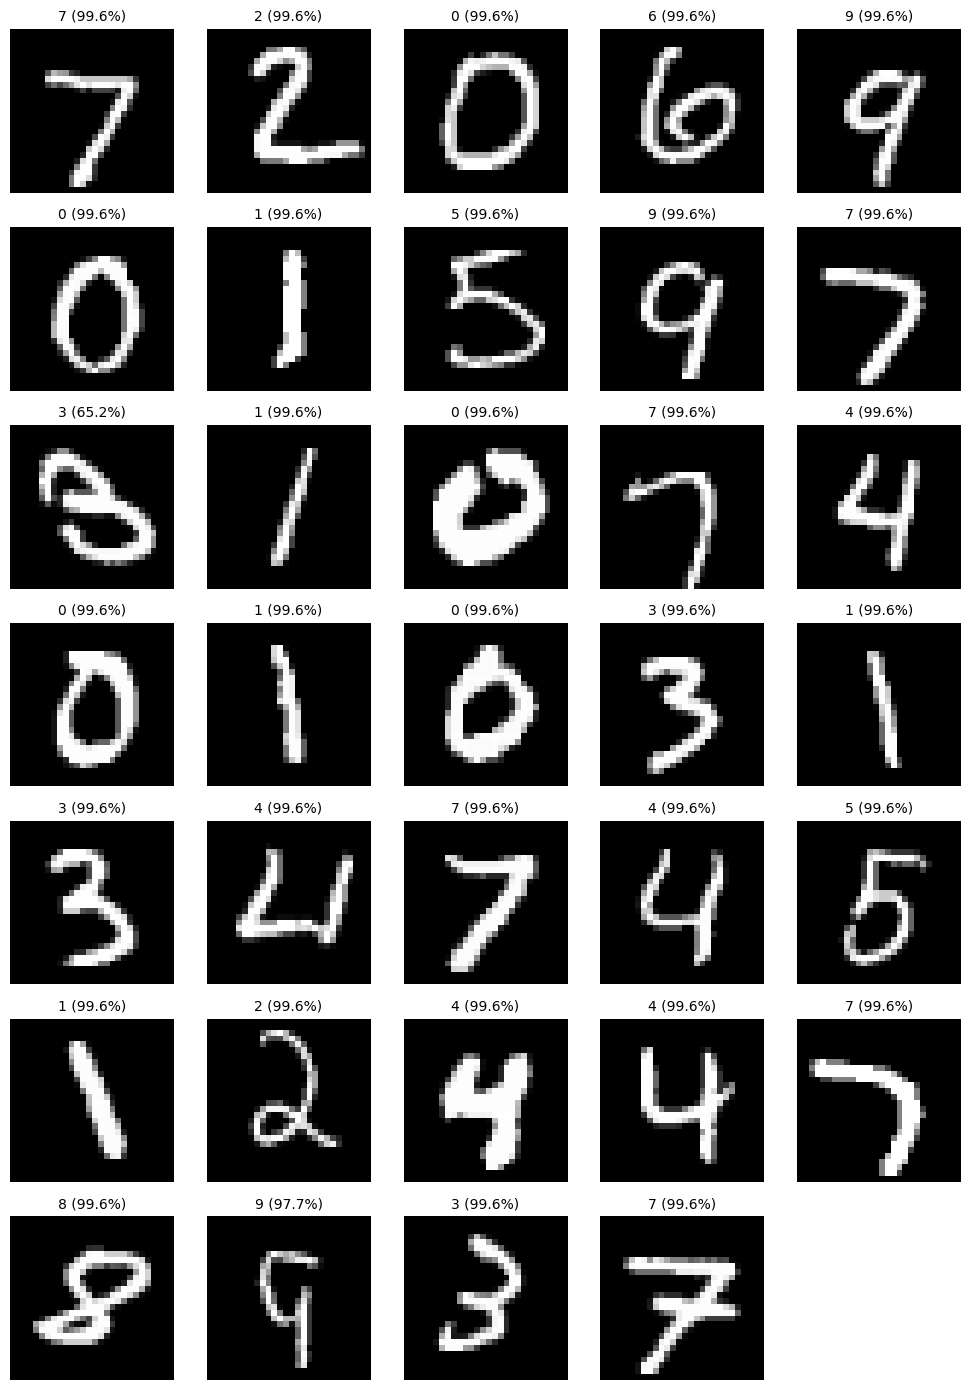

In [8]:
run_inference_on_directory(
    model_path="digits_model_28x28_int8_augmented_realworld.tflite", 
    image_dir="../../Dataset/MNIST_ORG/images",
    cols=5)

### 2. Test on images from the internet

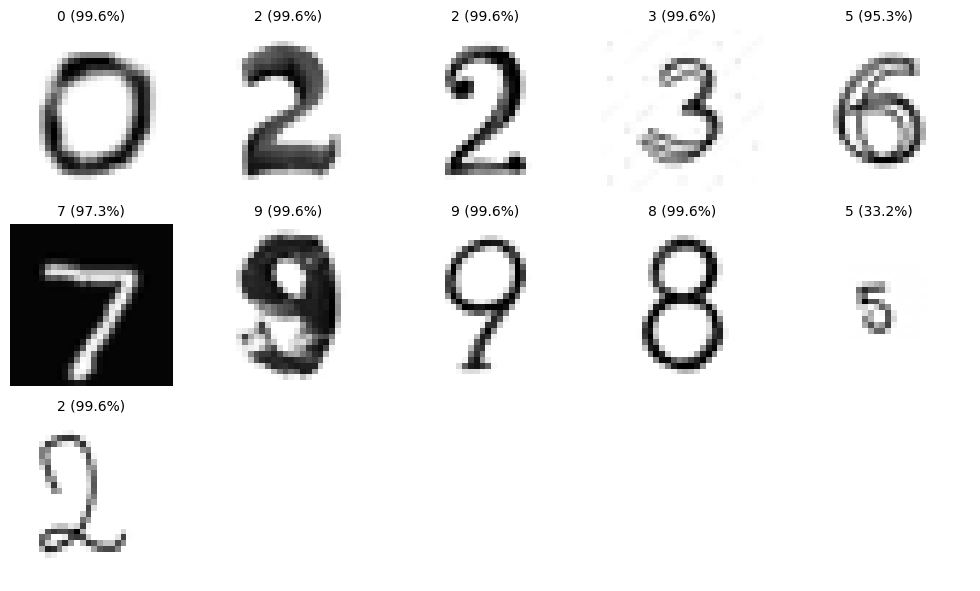

In [9]:
run_inference_on_directory(
    model_path="digits_model_28x28_int8_augmented_realworld.tflite", 
    image_dir="../../Dataset/internet/",
    cols=5)

### 3. Test on self written images

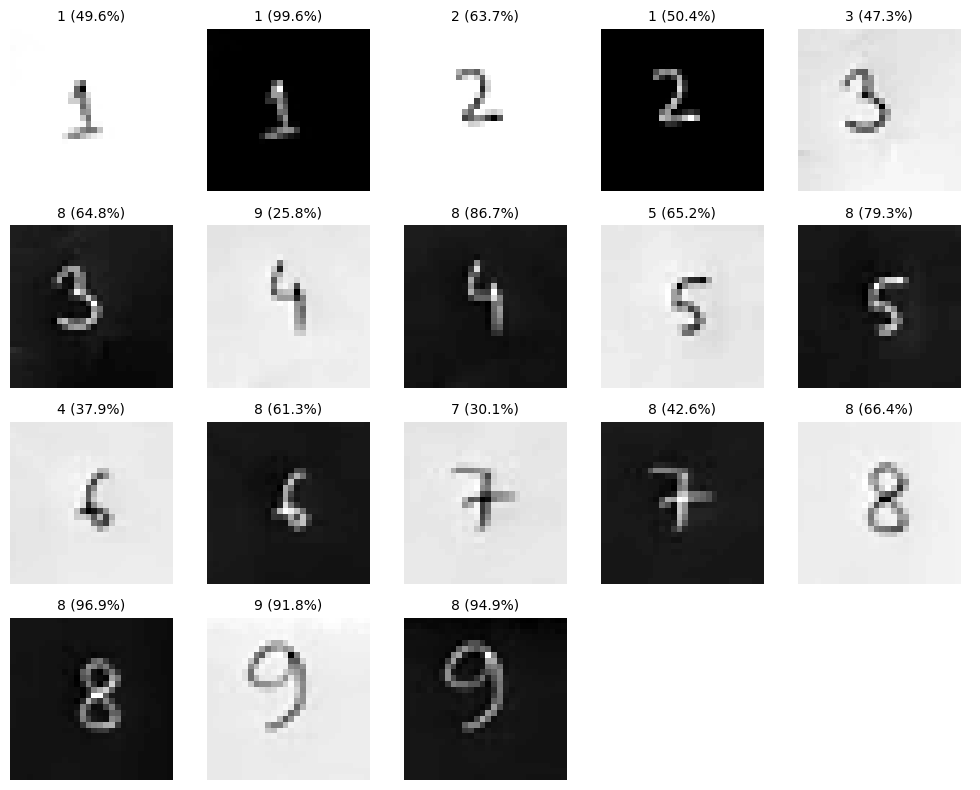

In [10]:
run_inference_on_directory(
    model_path="digits_model_28x28_int8_augmented_realworld.tflite", 
    image_dir="../../Dataset/self/",
    cols=5)